## ADA501 - Prosjekt

In [191]:
# !pip install numpy_financial

In [192]:
import pandas as pd
import numpy as np
import sympy as sp
from collections import namedtuple
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import numpy_financial as npf
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.integrate import odeint

## les inn csv filer

In [193]:
df = pd.read_excel('Siste.xlsx')
df_rente_kpi = pd.read_excel('siste_rente_kpi.xlsx')

Oppdeling av filen i df

In [194]:
# Filter 'Inntekt'
inntekt = df[df['Hva'] == 'Inntekt']
inntekt = inntekt.drop('Hva', axis=1)
# Filter 'Faste utgifter'
faste_utgifter = df[df['Hva'] == 'Fast utgift']
faste_utgifter = faste_utgifter.drop('Hva', axis=1)
# Filter 'Luksus'
forbruk = df[df['Hva'] == 'Luksus']
forbruk=forbruk.drop('Hva' , axis=1)
# Filter 'Rente'
rente = df_rente_kpi[['Dato', 'Rente']]
# Filter 'styringsrente'
kpi = df_rente_kpi[['Dato' , 'Konsumprisindeks(2015=100)', 'Månedsendring (prosent)']]

## Regressionsmodeller

Inntekt, Faste utgifter, forbruk, rente & styringsrente

Inntekt

In [195]:
# Dato til pd_datetime & float
inntekt['Brukt'] = inntekt['Brukt'].str.replace(',', '.')
inntekt['Brukt'] = inntekt['Brukt'].astype(float)
inntekt['Dato'] = pd.to_datetime(inntekt['Dato'])

Gjør om til måendlig

In [196]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_income = inntekt.groupby(inntekt['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_income = Monthly_income.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_income['Dato'] = Monthly_income['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
inntekt_måendlig = pd.DataFrame({'Dato': Monthly_income['Dato'], 'Income': Monthly_income['Brukt']})

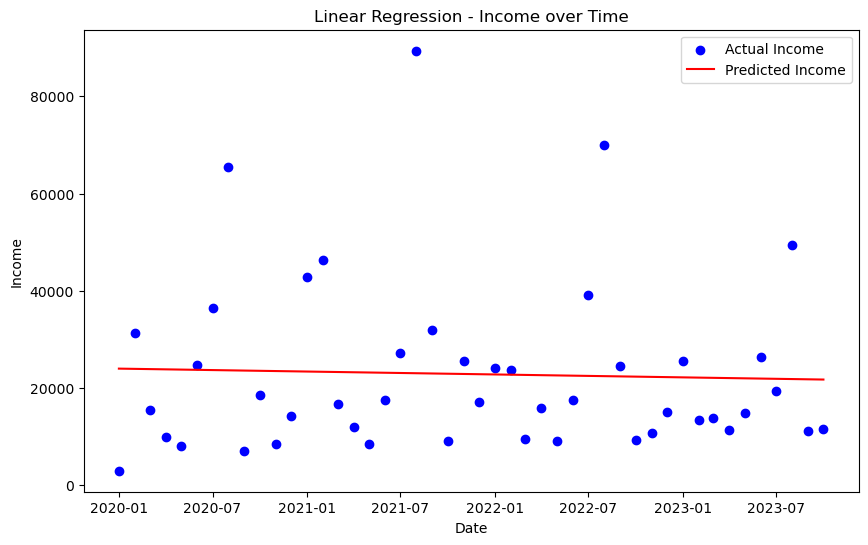

In [197]:
# Assuming you have your data stored in måendlig_inntekt DataFrame as described previously

# Convert 'Dato' column to datetime if it's in string format
inntekt_måendlig['Dato'] = pd.to_datetime(inntekt_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
inntekt_måendlig['Dato_numeric'] = (inntekt_måendlig['Dato'] - inntekt_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_inntekt = inntekt_måendlig[['Dato_numeric']]
y_inntekt = inntekt_måendlig['Income']

# Initialize Linear Regression model
model_inntekt = LinearRegression()

# Fit the model
model_inntekt.fit(X_inntekt, y_inntekt)

# Make predictions
predictions_inntekt = model_inntekt.predict(X_inntekt)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(inntekt_måendlig['Dato'], y_inntekt, color='blue', label='Actual Income')

# Plotting the regression line
plt.plot(inntekt_måendlig['Dato'], predictions_inntekt, color='red', label='Predicted Income')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Linear Regression - Income over Time')
plt.legend()
plt.show()


Faste utgifter

In [198]:
# Dato til pd_datetime & float
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].str.replace(',', '.')
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].astype(float)
faste_utgifter['Dato'] = pd.to_datetime(faste_utgifter['Dato'])

In [199]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_out = faste_utgifter.groupby(faste_utgifter['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_out = Monthly_out.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_out['Dato'] = Monthly_out['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
utgift_måendlig = pd.DataFrame({'Dato': Monthly_out['Dato'], 'Faste utgifter': Monthly_out['Brukt']})

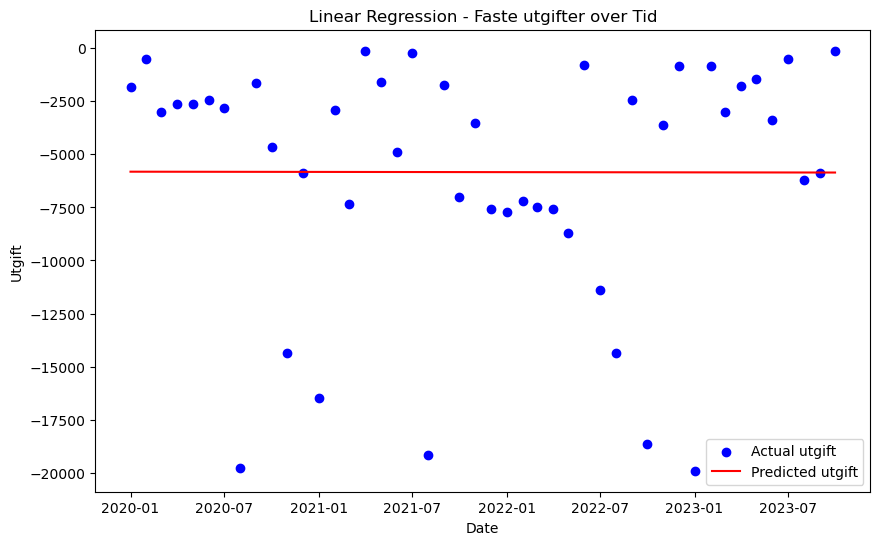

In [200]:
# Convert 'Dato' column to datetime if it's in string format
utgift_måendlig['Dato'] = pd.to_datetime(utgift_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
utgift_måendlig['Dato_numeric'] = (utgift_måendlig['Dato'] - utgift_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_utgift = utgift_måendlig[['Dato_numeric']]
y_utgift = utgift_måendlig['Faste utgifter']

# Initialize Linear Regression model
model_utgift = LinearRegression()

# Fit the model
model_utgift.fit(X_utgift, y_utgift)

# Make predictions
predictions_utgift = model_utgift.predict(X_utgift)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(utgift_måendlig['Dato'], y_utgift, color='blue', label='Actual utgift')

# Plotting the regression line
plt.plot(utgift_måendlig['Dato'], predictions_utgift, color='red', label='Predicted utgift')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

Har faste utgifter på 5750 kr i husleie nå + 4000 kr i mat, trening & mobil

Fast = 10 000 kr pr måend

Forbruk

In [201]:
# Dato til pd_datetime & float
forbruk['Brukt'] = forbruk['Brukt'].str.replace(',', '.')
forbruk['Brukt'] = forbruk['Brukt'].astype(float)
forbruk['Dato'] = pd.to_datetime(forbruk['Dato'])

In [202]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_forbruk = forbruk.groupby(forbruk['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_forbruk = Monthly_forbruk.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_forbruk['Dato'] = Monthly_forbruk['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
forbruk_måendlig = pd.DataFrame({'Dato': Monthly_forbruk['Dato'], 'Forbruk': Monthly_forbruk['Brukt']})

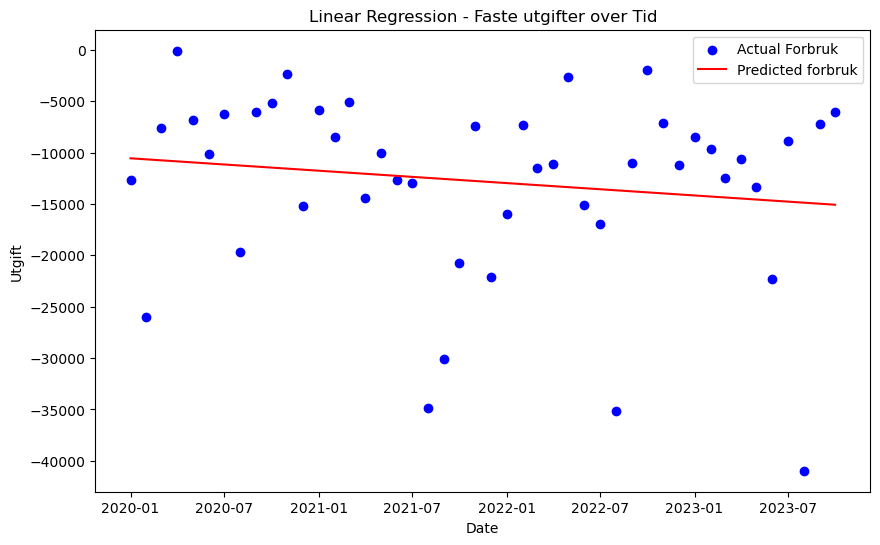

In [203]:
# Convert 'Dato' column to datetime if it's in string format
forbruk_måendlig['Dato'] = pd.to_datetime(forbruk_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
forbruk_måendlig['Dato_numeric'] = (forbruk_måendlig['Dato'] - forbruk_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_forbruk = forbruk_måendlig[['Dato_numeric']]
y_forbruk = forbruk_måendlig['Forbruk']

# Initialize Linear Regression model
model_forbruk = LinearRegression()

# Fit the model
model_forbruk.fit(X_forbruk, y_forbruk)

# Make predictions
predictions_forbruk = model_forbruk.predict(X_forbruk)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(forbruk_måendlig['Dato'], y_forbruk, color='blue', label='Actual Forbruk')

# Plotting the regression line
plt.plot(forbruk_måendlig['Dato'], predictions_forbruk, color='red', label='Predicted forbruk')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

Rente

C:\Users\even\AppData\Local\Temp\ipykernel_19896\1088633912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato'] = pd.to_datetime(rente['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_19896\1088633912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days


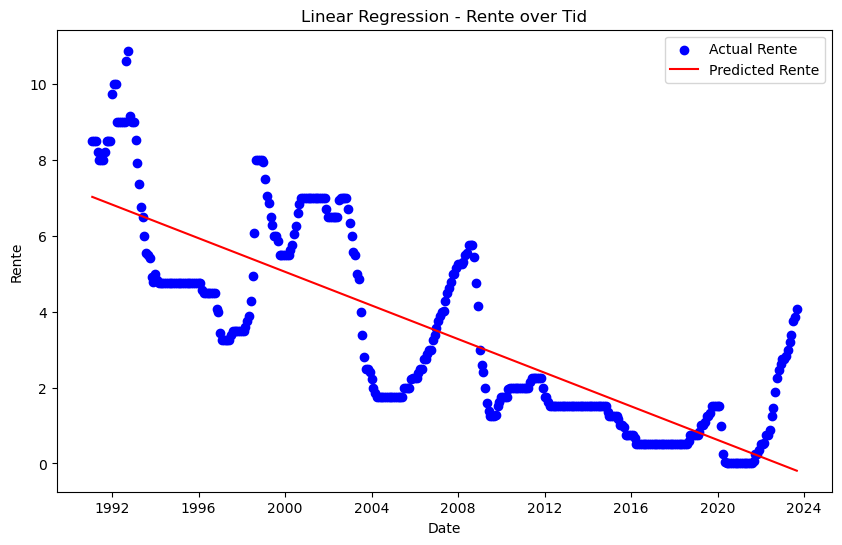

In [207]:
# Convert 'Dato' to datetime object
rente['Dato'] = pd.to_datetime(rente['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days

# Define the features and the target variable
X_rente = rente[['Dato_numeric']]
y_rente = rente['Rente']

# Initialize the Linear Regression model
model_rente = LinearRegression()

# Fit the model
model_rente.fit(X_rente, y_rente)

# Make predictions
predictions_rente = model_rente.predict(X_rente)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(rente['Dato'], y_rente, color='blue', label='Actual Rente')

# Plotting the regression line
plt.plot(rente['Dato'], predictions_rente, color='red', label='Predicted Rente')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Rente')
plt.title('Linear Regression - Rente over Tid')
plt.legend()
plt.show()


Inflasjon (KPI) i prosent og verdi

C:\Users\even\AppData\Local\Temp\ipykernel_19896\492207172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato'] = pd.to_datetime(kpi['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_19896\492207172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days


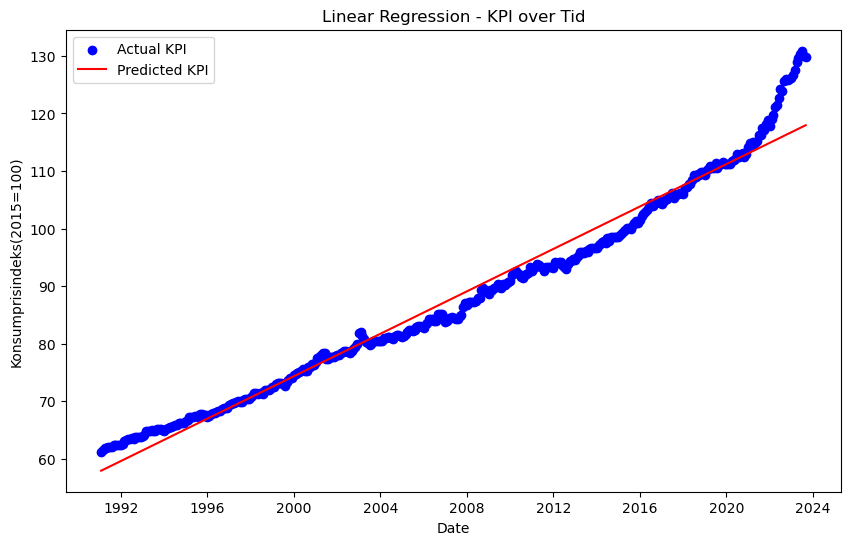

In [211]:
# Convert 'Dato' to datetime object
kpi['Dato'] = pd.to_datetime(kpi['Dato'])

kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days

X_kpi = kpi[['Dato_numeric']]
y_kpi = kpi['Konsumprisindeks(2015=100)']

model_kpi_r = LinearRegression()
model_kpi_r.fit(X_kpi, y_kpi)

predictions_kpi = model_kpi_r.predict(X_kpi)

plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(kpi['Dato'], y_kpi, color='blue', label='Actual KPI')

# Plotting the regression line
plt.plot(kpi['Dato'], predictions_kpi, color='red', label='Predicted KPI')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Konsumprisindeks(2015=100)')
plt.title('Linear Regression - KPI over Tid')
plt.legend()
plt.show()

C:\Users\even\AppData\Local\Temp\ipykernel_19896\1427202893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato'] = pd.to_datetime(kpi['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_19896\1427202893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days


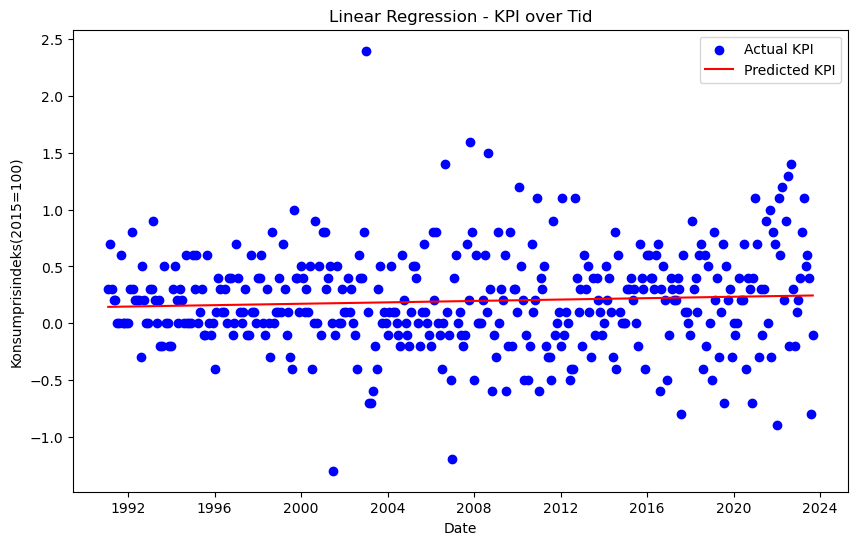

In [213]:
# Convert 'Dato' to datetime object
kpi['Dato'] = pd.to_datetime(kpi['Dato'])

kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days

X_kpi = kpi[['Dato_numeric']]
y_kpi = kpi['Månedsendring (prosent)']

model_kpi = LinearRegression()
model_kpi.fit(X_kpi, y_kpi)

predictions_kpi = model_kpi.predict(X_kpi)

plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(kpi['Dato'], y_kpi, color='blue', label='Actual KPI')

# Plotting the regression line
plt.plot(kpi['Dato'], predictions_kpi, color='red', label='Predicted KPI')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Konsumprisindeks(2015=100)')
plt.title('Linear Regression - KPI over Tid')
plt.legend()
plt.show()

ALLE variablene i df_rente_kpi

In [216]:
df_rente_kpi['Dato'] = pd.to_datetime(df_rente_kpi['Dato'])
df_rente_kpi['Dato_numeric'] = (df_rente_kpi['Dato'] - df_rente_kpi['Dato'].min()).dt.days

X = df_rente_kpi[['Dato_numeric', 'Konsumprisindeks(2015=100)', 'Månedsendring (prosent)']]
y = df_rente_kpi['Rente']

model_total = LinearRegression()
model_total.fit(X,y)

predictions_total = model_total.predict(X)

df_rente_kpi['Predicted Rente'] = predictions_total

from sklearn.metrics import mean_squared_error, r2_score

print('R-squared:', r2_score(y, predictions_total))
print('Mean Squared Error:', mean_squared_error(y, predictions_total))

R-squared: 0.7237735089671995
Mean Squared Error: 1.8413651090402954


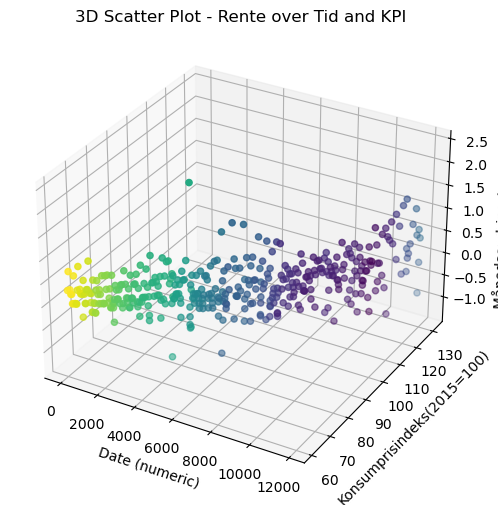

In [217]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data
ax.scatter(df_rente_kpi['Dato_numeric'], df_rente_kpi['Konsumprisindeks(2015=100)'], df_rente_kpi['Månedsendring (prosent)'], c=df_rente_kpi['Predicted Rente'], cmap='viridis')

# Labels
ax.set_xlabel('Date (numeric)')
ax.set_ylabel('Konsumprisindeks(2015=100)')
ax.set_zlabel('Månedsendring (prosent)')

# Title
ax.set_title('3D Scatter Plot - Rente over Tid and KPI')

plt.show()


Vi ser at for tid & kpi i % er dårlige mål

Problem med regressjon

In [221]:
# Get the maximum 'Dato_numeric' value in the original dataframe
max_date = df_rente_kpi['Dato_numeric'].max()

# Create a new dataframe with 'Dato_numeric' representing 15 years into the future
future_df = pd.DataFrame({
    'Dato_numeric': [max_date + 365*15]  # Add 15 years (365 days per year)
})


In [222]:
# Use the model to predict the rente in 15 years
future_rente = model_rente.predict(future_df)

print("The predicted rente in 15 years is:", future_rente[0])


The predicted rente in 15 years is: -3.509762505656793


Koeffisientene til regressjonsmodellen

In [225]:
# Get the coefficients of the model
coefficients = model_rente.coef_

# Print the coefficients with their meanings
for i, coef in enumerate(coefficients):
    print(f"The coefficient for 'Dato_numeric' is {coef}. It represents the average rate of change in 'Rente' for each additional day, assuming all other variables are held constant.")

The coefficient for 'Dato_numeric' is -0.0006060712809893146. It represents the average rate of change in 'Rente' for each additional day, assuming all other variables are held constant.


https://stats.stackexchange.com/questions/219579/what-is-wrong-with-extrapolation

In [ ]:
print(y0)

[21743.589800649133, -5856.267806100553, -15072.796409927078, 4.57, 0, 300000]


Inntekt de neste 25 årene - første 2 årene etter regression line, også etter 2 år, så hopper til 50 000 kr i måend

In [ ]:
# Define time for 25 periods (years)
future_time = np.array(range(1, t1 + 1)).reshape(-1, 1)  # Creating an array from 1 to 25 for future time

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


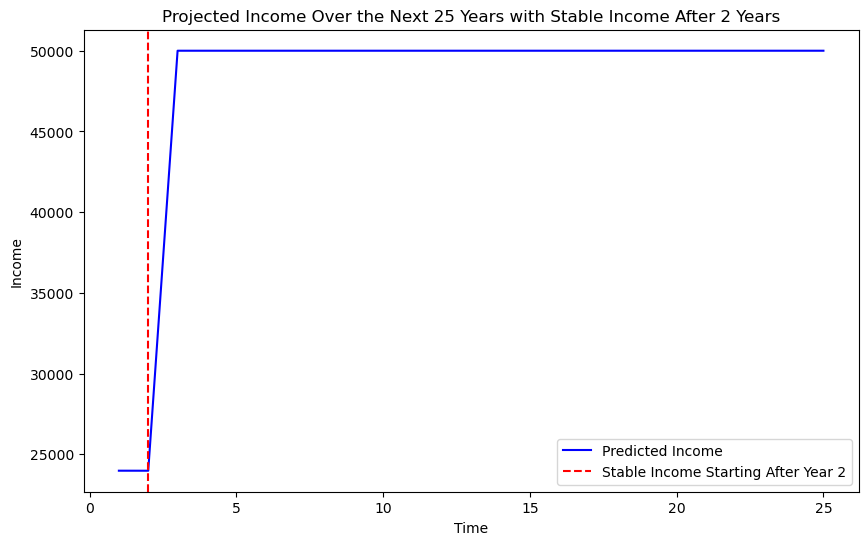

In [ ]:
# Predicting income for the next 25 years using the model
predicted_income_future = model_inntekt.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
stable_income = 50000  # Stable income value

# Apply the change in income prediction
predicted_income_future[change_index:] = stable_income

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_income_future, color='blue', label='Predicted Income')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected Income Over the Next 25 Years with Stable Income After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Faste utgifter - de neste 25 årene

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


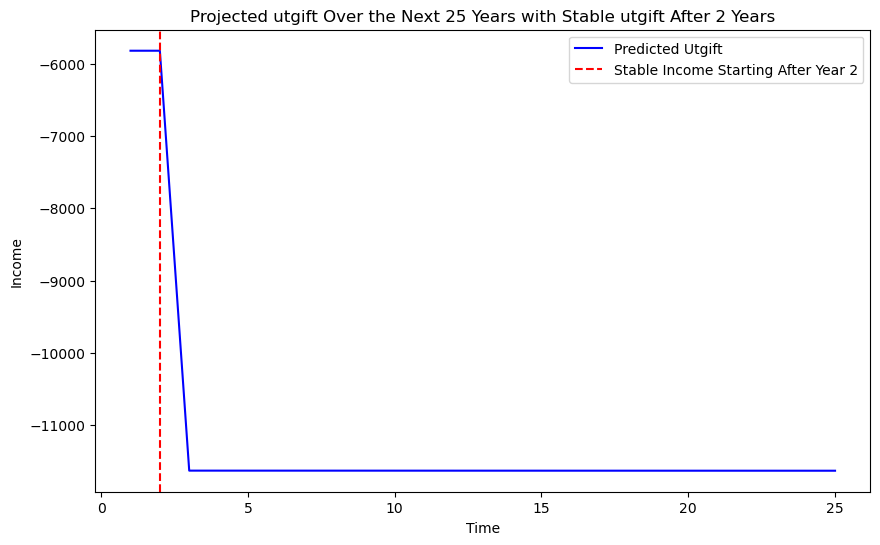

In [ ]:
# Predicting income for the next 25 years using the model
predicted_utgift_future = model_utgift.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Forbruk - de neste 25 årene

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


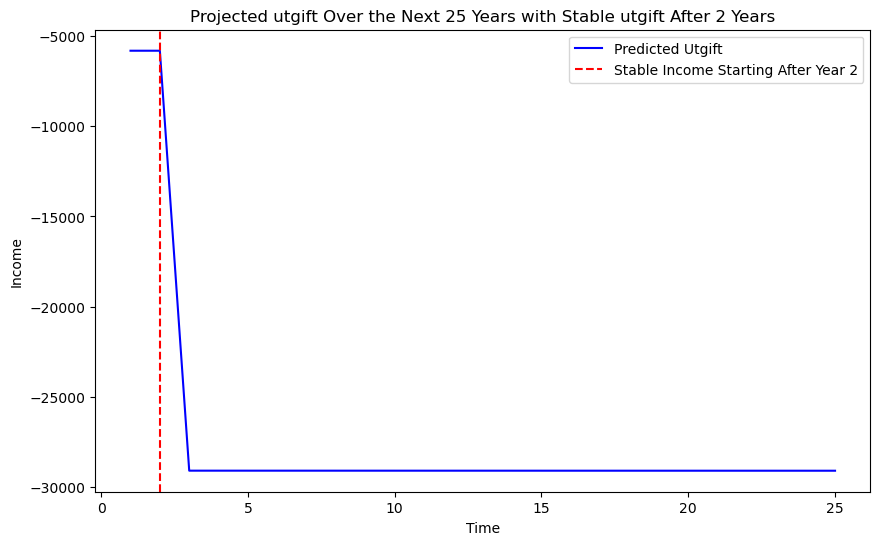

In [ ]:
# Predicting income for the next 25 years using the model
predicted_forbruk_future = model_forbruk.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2.5  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Forbruk ODE

In [ ]:
def forbruk_model(t, forbruk, inntekt, faste_utgifter, k1, k2):
   d_forbruk_dt = k1 * (inntekt - faste_utgifter) - (k2 * forbruk)
   return d_forbruk_dt

In [ ]:
def rente(rente, inflation): 
    target_inflation = 2.5  # Target inflation rate

    # Calculate the change in inflation based on the current inflation rate
    if inflation < target_inflation:  # If inflation is below target - 0.25%
        change = -0.025
    elif inflation > target_inflation:  # If inflation is above target + 0.25%
        change = 0.025
    else:  # Inflation is within the range of target -0.25% to target +0.25%
        change = 0  # No change

    # Update the inflation rate considering the change
    new_inflation = inflation + change

    # Return the new inflation rate
    return new_inflation

In [ ]:
def inflasjon(t, inflation, economic_factors, target_rate):
    adjustment = k4 * (economic_factors - target_rate)
    return adjustment

## TOTAL LØSNING

Initialisering

In [ ]:
I0 = predictions_inntekt[-1]                # Startinntekt pr måend
U0 = predictions_utgift[-1]                 # Faste utgifter
F0 = predictions_forbruk[-1]                # Initiale forbruksvaner
R0 = df_rente_kpi['Rente'].iloc[-1] +0.5    # Startboliglånsrenterente
S0 = 0                                      # Ønsker å starte med 0 kr
S1 = 300000                                 # Startsluttresultat over 25 år, vil ha et overskudd på konto

In [ ]:
k1 = 0.8        # Økning i forbruk etter inntekt                    -> hurtig økning etter inntektsøkning
k2 = 0.7        # Reduksjon i forbruk etter inntekt                 -> sakte endring etter inntektsfall
k3 = 0.3        # Renteendring basert på forbruk                    -> Forbruk øker -> Renter øker  -> Lånet påvirkes -> Må bruke mindre penger
k4 = 0.025      # Endring i inflasjon basert på forbuk & rente      -> Endres 0,25 poeng oftest

In [ ]:
t0 = 0
t1 = 25

# Definer tidsintervall og initialverdier
t = np.linspace(t0, t1, 1000)
y0 = [I0, U0, F0, R0, S0 , S1]

In [ ]:
# Define the system of ODEs
def system(variables, t):
    inntekt, faste_utgifter, forbruk, inflasjon = variables

    d_inntekt_dt = 0  # This would depend on your specific system
    d_faste_utgifter_dt = (inntekt - 6000) / t  # This represents the rate of change of 'faste utgifter'
    d_forbruk_dt = (inntekt - forbruk) / t  # This represents the rate of change of 'forbruk'
    d_inflasjon_dt = 0  # This would depend on your specific system

    return [d_inntekt_dt, d_faste_utgifter_dt, d_forbruk_dt, d_inflasjon_dt]

# Initial conditions
variables0 = [inntekt0, faste_utgifter0, forbruk0, inflasjon0]

# Time points
t = np.linspace(0, 15*365, 1000)

# Solve the system of ODEs
variables = odeint(system, variables0, t)

# Now 'variables' is a 2D array where the first column is 'inntekt', the second column is 'faste utgifter', etc.
# You can use this to make predictions about your system in the future.


## Ønsket lån

start kapital og lengde

In [ ]:
startKapital = 0    # startkapitalen
terminer = 300      # 12 terminer over 25 år

Serielån

In [ ]:
def calculate_serial_loan(principal, annual_interest_rate, loan_term):
    # Convert annual interest rate to monthly
    monthly_interest_rate = annual_interest_rate / 12 / 100

    # Convert loan term to months
    loan_term_months = loan_term * 12

    # Calculate the monthly payment
    monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate) ** loan_term_months) / ((1 + monthly_interest_rate) ** loan_term_months - 1)

    return monthly_payment

# Example usage:
principal = 200000  # Loan amount
annual_interest_rate = 5.5  # Annual interest rate (%)
loan_term = 25  # Loan term in years

monthly_payment = calculate_serial_loan(principal, annual_interest_rate, loan_term)

print(f"The monthly payment for a serial loan of {principal} with an annual interest rate of {annual_interest_rate}% for a term of {loan_term} years is {monthly_payment:.2f}.")

Annuitetslån

In [ ]:
def calculate_annual_loan(principal, annual_interest_rate, loan_term):
    # Convert annual interest rate to decimal
    annual_interest_rate_decimal = annual_interest_rate / 100

    # Calculate the annual payment
    annual_payment = principal * (annual_interest_rate_decimal * (1 + annual_interest_rate_decimal) ** loan_term) / ((1 + annual_interest_rate_decimal) ** loan_term - 1)

    return annual_payment

# Example usage:
principal = 200000  # Loan amount
annual_interest_rate = 5.5  # Annual interest rate (%)
loan_term = 25  # Loan term in years

annual_payment = calculate_annual_loan(principal, annual_interest_rate, loan_term)

print(f"The annual payment for an annual loan of {principal} with an annual interest rate of {annual_interest_rate}% for a term of {loan_term} years is {annual_payment:.2f}.")
